In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import yfinance as yf
import talib
import numpy as np

# Download necessary NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:

def get_stock_data(ticker, start='2020-01-01'):
    # Fetch all available historical data
    data = yf.download(ticker, progress=False)
    
    # Ensure the Close column is a 1D array before passing to TA-Lib
    close_prices = data['Close'].astype(float).values.flatten()

    data['RSI'] = talib.RSI(close_prices, timeperiod=14)
    data['MA_10'] = talib.SMA(close_prices, timeperiod=10)
    data['MA_30'] = talib.SMA(close_prices, timeperiod=30)
    data['MA_50'] = talib.SMA(close_prices, timeperiod=50)
    data['MA_200'] = talib.SMA(close_prices, timeperiod=200)

    upper, middle, lower = talib.BBANDS(close_prices, timeperiod=20)
    data['Upper_Band'] = upper
    data['Lower_Band'] = lower

    data.dropna(inplace=True)
    return data

# Example Usage
 # Display the first few rows


In [18]:
def preprocess_lstm_data(df, columns=['Close'], time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[columns])
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

# Build LSTM Model with Optimizations
def build_stacked_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [19]:
def train_lstm_model(X_train, y_train,X_test, y_test ,model_name,epoch):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=3.1250e-05, verbose=1)
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32,validation_data=(X_test, y_test), verbose=1, callbacks=[lr_scheduler])
    model.save(f"prediction_forcaste_20201.keras")
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model

# Sentiment Analysis
def get_sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    return score

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_ensemble(ticker, forecast_days=30, epoch=50):
    df = get_stock_data(ticker)
    time_step = 60
    
    # Ensure the correct columns are selected for feature engineering (Only 'Close' for indices)
    feature_columns = ['Close']
    
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test, y_test = X[-forecast_days:], y[-forecast_days:]

    try:
        model = load_model(f"prediction_forcaste_20201.keras")
    except:
        model = train_lstm_model(X_train, y_train, X_test, y_test, ticker, epoch)

    predictions = model.predict(X_test)

    # Create an empty array for inverse transform with correct shape
    dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))  # (30, 1)
    dummy_array[:, 0] = predictions[:, 0]  # Fill only the Close column

    # Inverse transform using the full shape
    predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the Close column

    # Inverse transform actual y values
    y_actual = np.zeros((y_test.shape[0], len(feature_columns)))
    y_actual[:, 0] = y_test  # Fill only the Close column
    y_actual = scaler.inverse_transform(y_actual)[:, 0]  # Extract only Close column

    # Sentiment Adjustment
    headline = f"{ticker} stock market update"
    sentiment_score = get_sentiment_score(headline)
    sentiment_adjustment = 1 + (sentiment_score * 0.03)
    adjusted_preds = predictions * sentiment_adjustment

    # Calculate Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(y_actual, adjusted_preds))
    mae = mean_absolute_error(y_actual, adjusted_preds)
    mape = np.mean(np.abs((y_actual - adjusted_preds) / y_actual)) * 100
    r2 = r2_score(y_actual, adjusted_preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print("R^2 Score:", r2)

    # Plot Results
    last_dates = df.index[-forecast_days:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_dates, y_actual, label='Actual')
    
    plt.plot(last_dates, adjusted_preds, label='Ensemble Forecast (Sentiment)', linestyle='--')
    plt.title(f"{ticker} - Enhanced Ensemble Forecast ({forecast_days} days), {epoch} Epochs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [21]:
df = get_stock_data("RELIANCE.NS")  # Replace with your stock ticker
df 

Price,Close,High,Low,Open,Volume,RSI,MA_10,MA_30,MA_50,MA_200,Upper_Band,Lower_Band
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,,
Date,,,,,,,,,,,,
1996-10-04,3.694582,3.724612,3.608369,3.695551,180091079,39.823246,3.723837,3.893681,3.944757,3.964189,4.025344,3.586524
1996-10-07,3.622900,3.703301,3.496970,3.703301,272128046,36.037580,3.709694,3.879312,3.934992,3.964095,3.996848,3.575594
1996-10-08,3.638398,3.681021,3.517312,3.605463,196707309,37.422676,3.694195,3.866557,3.927708,3.964220,3.968939,3.569211
1996-10-09,3.685864,3.719768,3.627742,3.681020,175357589,41.594135,3.680731,3.851640,3.918582,3.964446,3.943349,3.569519
1996-10-10,3.784670,3.797263,3.657772,3.675209,194458201,49.187490,3.683152,3.841307,3.912945,3.965333,3.924101,3.576270
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-28,1275.099976,1295.750000,1269.000000,1280.000000,18147129,57.700779,1268.424988,1234.701668,1245.083999,1360.224517,1319.400084,1164.914918
2025-04-01,1252.599976,1277.900024,1249.300049,1264.599976,12099648,50.443446,1269.799988,1235.918335,1244.088999,1359.195640,1319.661711,1169.903291


In [22]:
forecast_ensemble("RELIANCE.NS",epoch=250)


Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [24]:
forecast_ensemble("RELIANCE.NS",epoch=50)

Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.0250 - val_loss: 0.1566 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0042 - val_loss: 0.1552 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0023 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.0015 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 0.0018 - val_loss: 5.8122e-04 - learning_rate: 0.0010
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0011 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 9.3543e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 9.2121e-04 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 9.9757e-04 - val_loss: 4.2493e-04 - learn

: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
RMSE: 30.183662128457012
MAE: 23.40356184740837
MAPE: 1.8803364231638147
R^2 Score: 0.21142967813671742


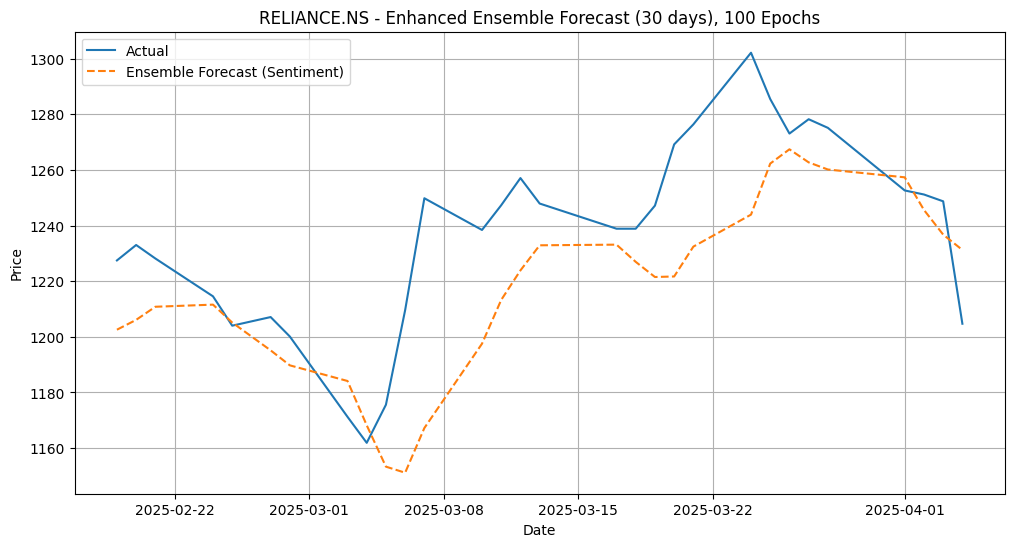

In [ ]:
forecast_ensemble("RELIANCE.NS",epoch=100)